      Name:            Uni:
      Jinhan Cheng     jc4834
      Xiangzi Meng     xmm2103

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier

In [3]:
from scipy.io import loadmat
hw4data=loadmat('annthyroid.mat')

In [4]:
X = hw4data['X']
y = hw4data['y']
y = np.int64(y.ravel())
X_scaled = StandardScaler().fit_transform(X)

In [5]:
print(X.shape)
print(y.shape)

(7200, 6)
(7200,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Task 1 Visualization

## 

### Univariate Distributions of all Features

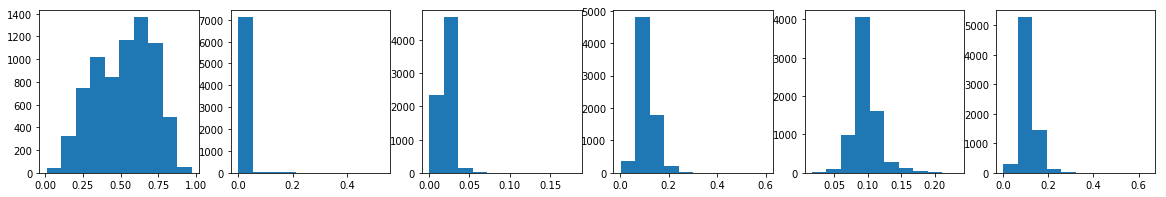

In [231]:
fig, ax = plt.subplots(1, 6, figsize=(20, 3))
for i in range(6):
    ax[i].hist(X[:, i])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a381630b8>,
      dtype=object)

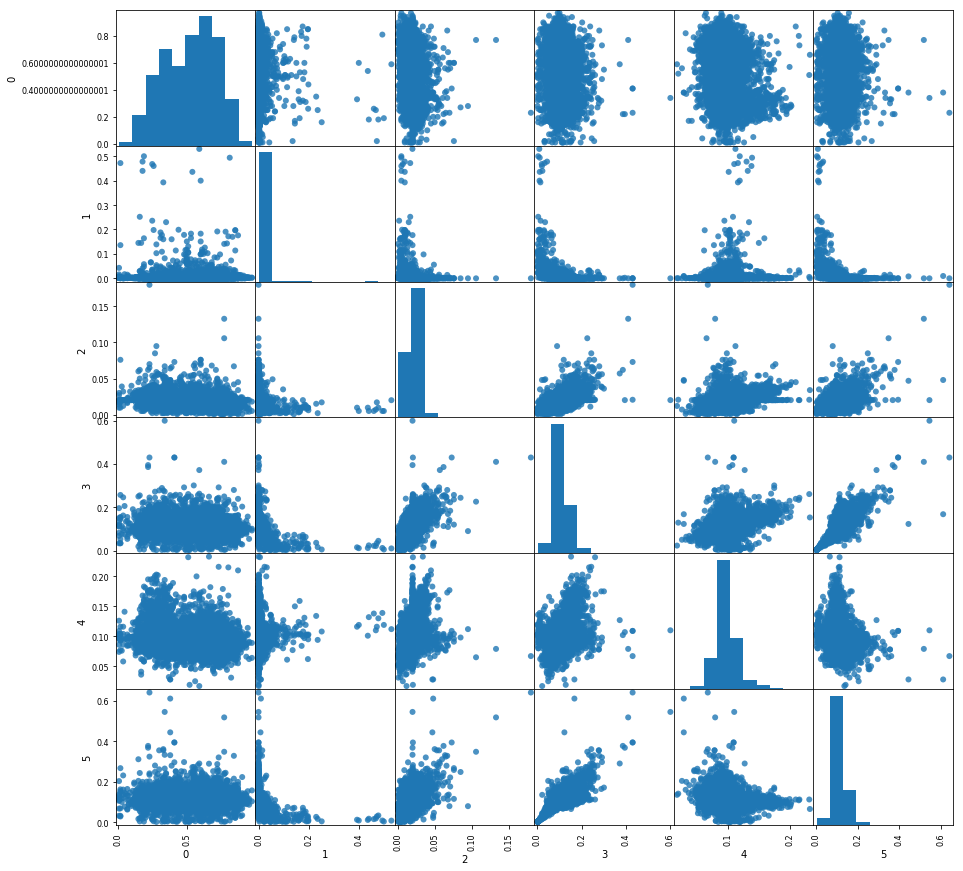

In [232]:
%matplotlib inline 
dataframe = pd.DataFrame(X)
pd.plotting.scatter_matrix(dataframe, marker='o', alpha=.8, figsize=(15, 15))

### PCA Visualization

In [104]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

Text(0,0.5,'second principal component')

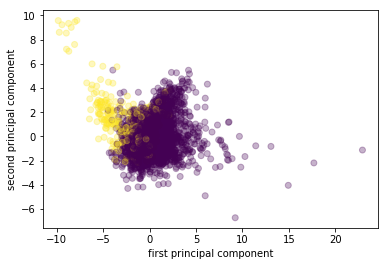

In [105]:
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(X)
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], alpha=.3, c=y)
plt.xlabel("first principal component")
plt.ylabel("second principal component")

### Explained Variance Ratio in PCA

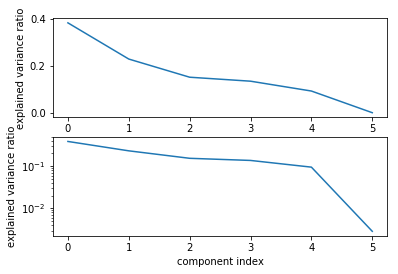

In [106]:
pca_scaled = make_pipeline(StandardScaler(), PCA())
pca_scaled.fit(X_train, y_train)
pca = pca_scaled.named_steps['pca']

fig, axes = plt.subplots(2)
axes[0].plot(pca.explained_variance_ratio_)
axes[1].semilogy(pca.explained_variance_ratio_)
for ax in axes:
    ax.set_xlabel("component index")
    ax.set_ylabel("explained variance ratio")

### A Good Threshold

Looking at the plot of explained variance ratio in PCA, a good threshold is between 4 and 5.

## 

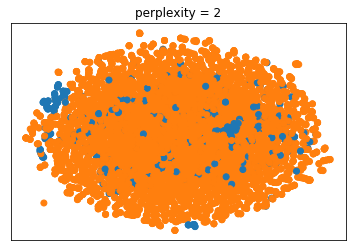

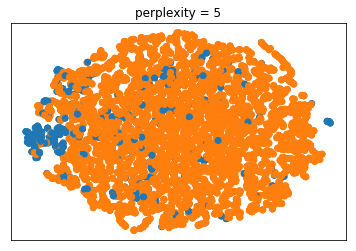

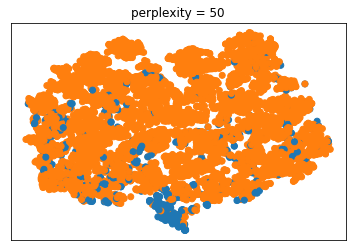

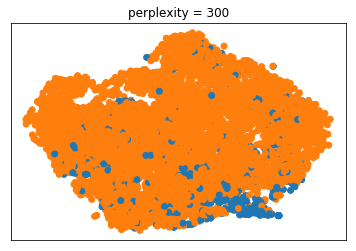

In [33]:
from sklearn.manifold import TSNE
for perplexity in [2, 5, 50, 300]:
    plt.figure()
    plt.xticks(())
    plt.yticks(())
    X_tsne = TSNE(perplexity=perplexity).fit_transform(X_scaled)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=plt.cm.Vega10(y))
    plt.title("perplexity = {}".format(perplexity))
    plt.savefig("./tsne-tuning-{}".format(perplexity))

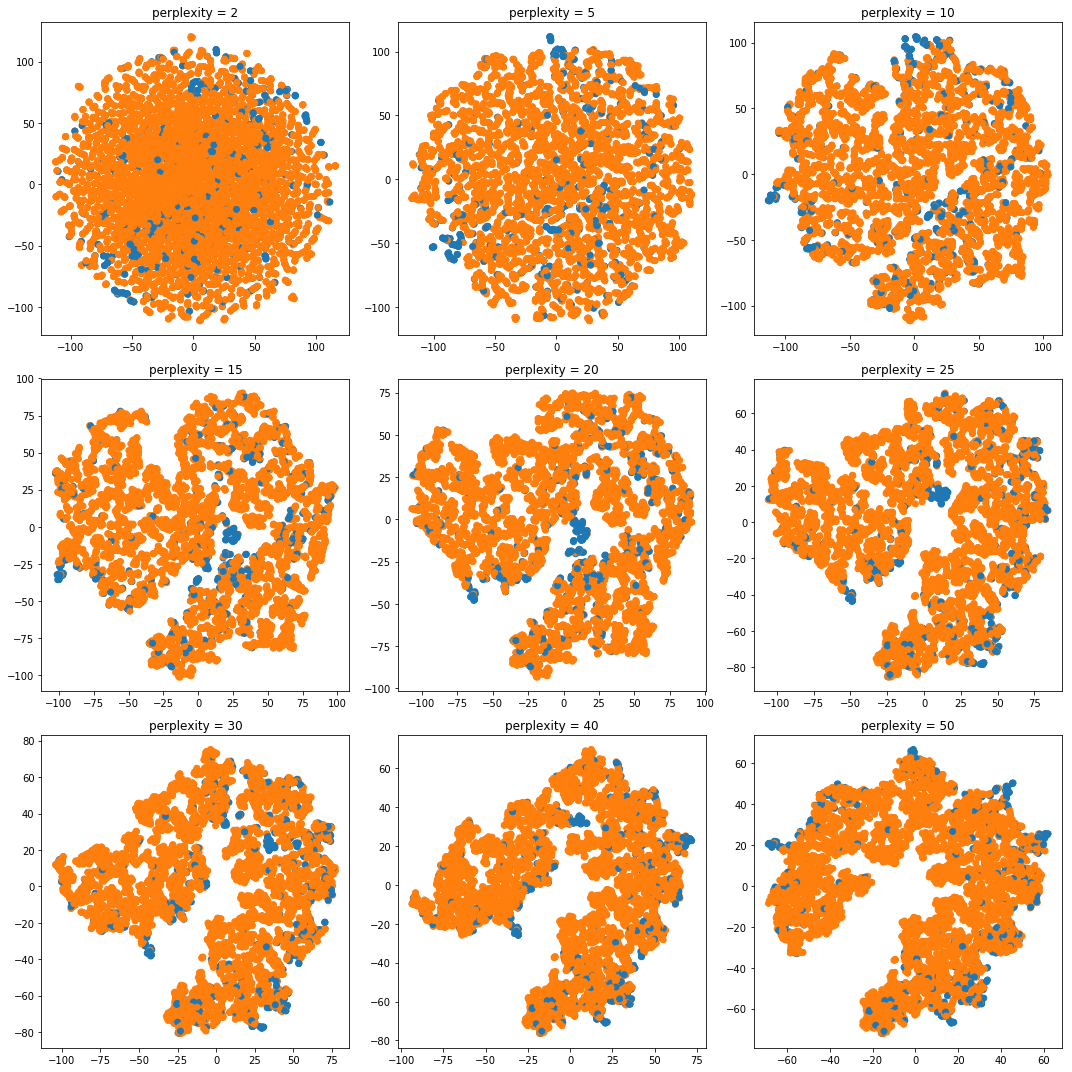

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for ax, perplexity in zip(axes.ravel(), [2, 5, 10, 15, 20, 25, 30, 40, 50]):
    X_tsne = TSNE(perplexity=perplexity, random_state=0).fit_transform(X_scaled)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=plt.cm.Vega10(y))
    ax.set_title("perplexity = {}".format(perplexity))
fig.tight_layout()

We could see from the plots above that tuning the perplexity parameter could help a little to obtain a better visualization.

# Task 2 Clustering

##

In [34]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

### KMeans

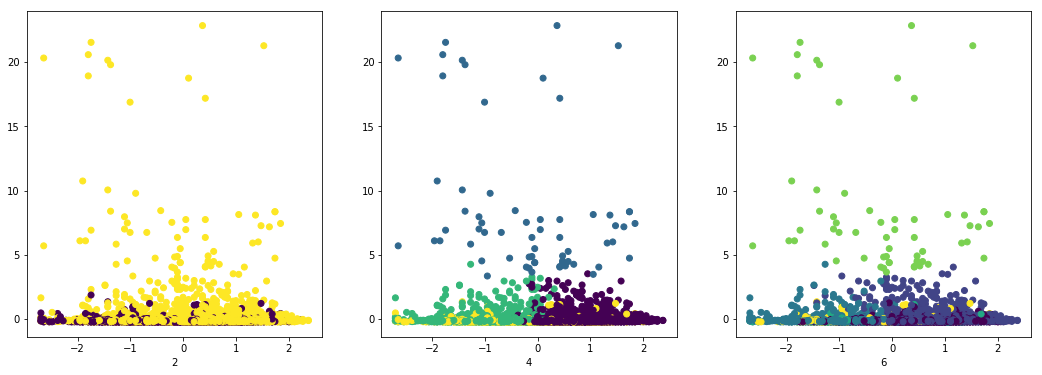

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
i = 0
for parameter in [2,4,6]:
    km = KMeans(n_clusters=parameter, random_state=42)
    km.fit(X_scaled)

    ax[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=km.labels_)
    ax[i].set_xlabel(parameter)
    i += 1

### AgglomerativeClustering

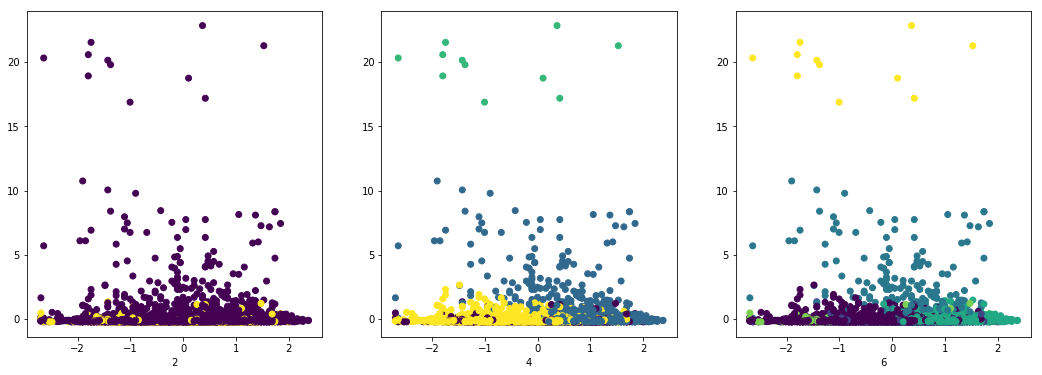

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
i = 0
for parameter in [2,4,6]:
    ag = AgglomerativeClustering(n_clusters=parameter, linkage='ward')
    ag.fit(X_scaled)

    ax[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=ag.labels_)
    ax[i].set_xlabel(parameter)
    i += 1

### DBSCAN

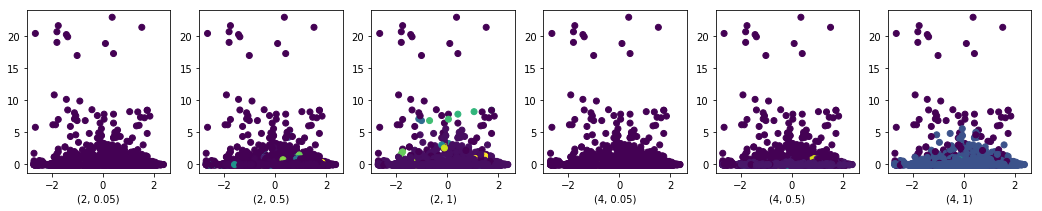

In [46]:
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
i = 0
for param1 in [2,4]:
    for param2 in [0.05, 0.5, 1]:
        db = DBSCAN(min_samples=param1, eps=param2)
        db.fit(X_scaled)

        ax[i].scatter(X_scaled[:, 0], X_scaled[:, 1], c=db.labels_)
        ax[i].set_xlabel((param1, param2))
        i += 1

### Dendrogram for Agglomerative Clustering

Text(0,0.5,'Cluster distance')

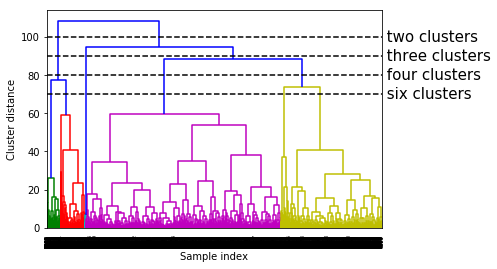

In [62]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(X_scaled)
dendrogram(linkage_array,truncate_mode='level')
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [100, 100], '--', c='k')
ax.plot(bounds, [90, 90], '--', c='k')
ax.plot(bounds, [80, 80], '--', c='k')
ax.plot(bounds, [70, 70], '--', c='k')
ax.text(bounds[1], 100, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 90, ' three clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 80, ' four clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 70, ' six clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

If we know the proportion of outliers, and there exist a cluster we have found whose size is similar to the known proportion of outliers, then the result would be quite meaningful.

In [96]:
y.mean()

0.07416666666666667

Using the known groudtruth, the proportion of outliers is around 0.074. If a cluster's size is of around 7.4%, it would be meaningful.

##

In [64]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

### NMI and ARI Scores of KMeans

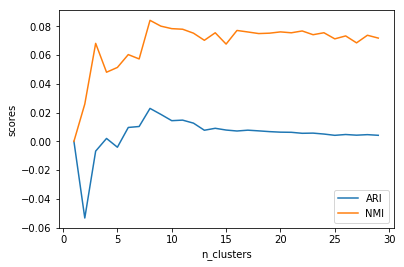

In [94]:
aris, nmis = [], []
n_clusters_km = []
for i in range(1, 30):
    km = KMeans(n_clusters=i, n_init=10, init="random").fit(X_scaled)
    ari = adjusted_rand_score(y, km.labels_)
    nmi = normalized_mutual_info_score(y, km.labels_)
    aris.append(ari)
    nmis.append(nmi)
    n_clusters_km.append(i)
plt.plot(n_clusters_km, aris, label="ARI")
plt.plot(n_clusters_km, nmis, label="NMI")
plt.xlabel("n_clusters")
plt.ylabel("scores")
plt.legend()

Based on the known ground truth labels of the outlier vs inlier class, the NMI and ARI scores are quite low.<br/>

Changing the parameters for example n_clusters would change the scores, however there is not much improvement.

### NMI and ARI Scores of Agglomerative Clustering

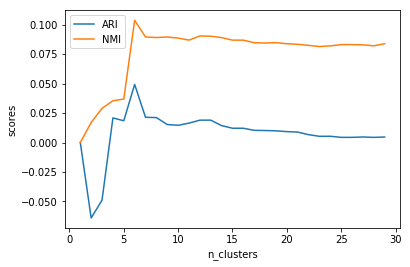

In [95]:
aris, nmis = [], []
n_clusters_ag = []
for i in range(1, 30):
    ag = AgglomerativeClustering(n_clusters=i, linkage='ward').fit(X_scaled)
    ari = adjusted_rand_score(y, ag.labels_)
    nmi = normalized_mutual_info_score(y, ag.labels_)
    aris.append(ari)
    nmis.append(nmi)
    n_clusters_ag.append(i)
plt.plot(n_clusters_ag, aris, label="ARI")
plt.plot(n_clusters_ag, nmis, label="NMI")
plt.xlabel("n_clusters")
plt.ylabel("scores")
plt.legend()

Based on the known ground truth labels of the outlier vs inlier class, the NMI and ARI scores are quite low.<br/>

Changing the parameters for example n_clusters would change the scores, however there is not much improvement.

### NMI and ARI Scores of DBSCAN

0.2
0.2947368421052632
0.3894736842105263
0.4842105263157895
0.5789473684210527
0.6736842105263159
0.7684210526315789
0.8631578947368421
0.9578947368421054
1.0526315789473684
1.1473684210526316
1.2421052631578948
1.3368421052631578
1.431578947368421
1.5263157894736843
1.6210526315789473
1.7157894736842105
1.8105263157894738
1.9052631578947368
2.0


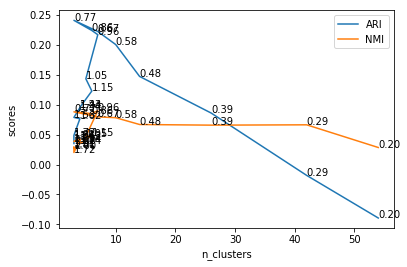

In [93]:
aris, nmis = [], []
n_clusters_db = []
for eps in np.linspace(.2, 2, 20):
    print(eps)
    db = DBSCAN(eps=eps).fit(X_scaled)
    ari = adjusted_rand_score(y, db.labels_)
    nmi = normalized_mutual_info_score(y, db.labels_)
    aris.append(ari)
    nmis.append(nmi)
    n_clusters_db.append(len(np.unique(db.labels_)))
plt.plot(n_clusters_db, aris, label="ARI")
plt.plot(n_clusters_db, nmis, label="NMI")
for eps, n_clusters, aris, nmis in zip(np.linspace(.2, 2, 20), n_clusters_db, aris, nmis):
    plt.text(n_clusters, aris, "{:.2f}".format(eps))
    plt.text(n_clusters, nmis, "{:.2f}".format(eps))
plt.xlabel("n_clusters")
plt.ylabel("scores")
plt.legend()                            

Based on the known ground truth labels of the outlier vs inlier class, the NMI and ARI scores are quite low.<br/>

changing the parameters for example eps could change the scores, however there is not much improvement.

# Task 3 Outlier Detection

##

In [107]:
np.place(y, y == 1, -1)
np.place(y, y == 0, 1)

### EllipticEnvelope

In [137]:
from sklearn.covariance import EllipticEnvelope
ee = EllipticEnvelope(contamination=.1).fit(X_scaled)
ee_pred = ee.predict(X_scaled)
print("Predicted proportion of outliers with EllipticEnvelope: {:.4f}".format(np.mean(ee_pred == -1)))

Predicted proportion of outliers with EllipticEnvelope: 0.1000


### OneClassSVM

In [142]:
from sklearn.svm import OneClassSVM
oneclass = OneClassSVM(nu=.1).fit(X_scaled)
oneclass_pred = oneclass.predict(X_scaled).astype(np.int)
print("Predicted proportion of outliers with OneClassSVM: {:.4f}".format(np.mean(oneclass_pred == -1)))

Predicted proportion of outliers with OneClassSVM: 0.0999


### IsolationForest

In [136]:
from sklearn.ensemble import IsolationForest
ppo_iso = []
for i in range(1, 100):
    iso = IsolationForest(contamination='auto').fit(X)
    iso_pred = iso.predict(X)
    ppo_iso.append(np.mean(iso_pred == -1))
print("Predicted proportion of outliers with IsolationForest: {:.4f}".format(np.mean(ppo_iso)))

Predicted proportion of outliers with IsolationForest: 0.0769


IsolationForest gives the best result.<br/>

As for predicted proportion of outliers, EllipticEnvelop and OneClassSVM always return the contamination or nu values we have input.<br/>

However, when we use IsolationForest and set the contamination to 'auto', it returns values very close to 0.74, which is the outlier proportion we have already computed before, it is quite accurate without giving it a specific contamination rate. Then if we give it the exact contamination and predict, I would have better result than EllipticEnvelop and OneClassSVM.

##

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
np.place(y_train, y_train == 1, -1)
np.place(y_train, y_train == 0, 1)
np.place(y_test, y_test == 1, -1)
np.place(y_test, y_test == 0, 1)

### EllipticEnvelope

In [153]:
ee = EllipticEnvelope(contamination=.1).fit(X_train_scaled)
print("Training set AUC score with EllipticEnvelop: {:.4f}".format(roc_auc_score(y_train,ee.decision_function(X_train_scaled))))
print("Training set Average Precision score with EllipticEnvelop: {:.4f}".format(average_precision_score(y_train, ee.decision_function(X_train_scaled))))
print("Test set AUC score with EllipticEnvelop: {:.4f}".format(roc_auc_score(y_test,ee.decision_function(X_test_scaled))))
print("Test set Average Precision score with EllipticEnvelop: {:.4f}".format(average_precision_score(y_test, ee.decision_function(X_test_scaled))))

Training set AUC score with EllipticEnvelop: 0.9135
Training set Average Precision score with EllipticEnvelop: 0.9929
Test set AUC score with EllipticEnvelop: 0.9260
Test set Average Precision score with EllipticEnvelop: 0.9931


### OneClassSVM

In [150]:
oneclass = OneClassSVM(nu=.1).fit(X_train_scaled)
print("Training set AUC score with OneClassSVM: {:.4f}".format(roc_auc_score(y_train,oneclass.decision_function(X_train_scaled))))
print("Training set Average Precision score with OneClassSVM: {:.4f}".format(average_precision_score(y_train, oneclass.decision_function(X_train_scaled))))
print("Test set AUC score with OneClassSVM: {:.4f}".format(roc_auc_score(y_test,oneclass.decision_function(X_test_scaled))))
print("Test set Average Precision score with OneClassSVM: {:.4f}".format(average_precision_score(y_test, oneclass.decision_function(X_test_scaled))))

Training set AUC score with OneClassSVM: 0.5943
Training set Average Precision score with OneClassSVM: 0.9331
Test set AUC score with OneClassSVM: 0.6390
Test set Average Precision score with OneClassSVM: 0.9298


### IsolationForest

In [156]:
iso = IsolationForest(contamination='auto').fit(X_train)
print("Training set AUC score with IsolationForest: {:.4f}".format(roc_auc_score(y_train,iso.decision_function(X_train))))
print("Training set Average Precision score with IsolationForest: {:.4f}".format(average_precision_score(y_train, iso.decision_function(X_train))))
print("Test set AUC score with IsolationForest: {:.4f}".format(roc_auc_score(y_test,iso.decision_function(X_test))))
print("Test set Average Precision score with IsolationForest: {:.4f}".format(average_precision_score(y_test, iso.decision_function(X_test))))

Training set AUC score with IsolationForest: 0.8252
Training set Average Precision score with IsolationForest: 0.9842
Test set AUC score with IsolationForest: 0.8422
Test set Average Precision score with IsolationForest: 0.9836


When comparing with the clustering approaches from Task 2, the scores from Task 3 are far more better than scores from Task 2. Using metrics like ARI and NMI usually only helps in developing algorithms, not in assessing success in an application, it is hard to compare performance between ARI/NMI with AUC/Average Precision score. So we need to compute the AUC and Average Precision score of the approaches in Task 3 to make better model selection.

# Task 4 Imbalanced Classification

## LogisticRegression

### Plot AUC Scores with Different "C"

In [16]:
param_grid = {'C' : np.logspace(-3,3,100)}
g1_lgr = GridSearchCV(LogisticRegression(), param_grid, cv=10, return_train_score=True, scoring='roc_auc', iid=True)
g1_lgr.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 1.14976e-03, ..., 8.69749e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [17]:
param_grid = {'C' : np.logspace(-3,3,100)}
g2_lgr = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=10, return_train_score=True, scoring='roc_auc', iid=True)
g2_lgr.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 1.14976e-03, ..., 8.69749e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

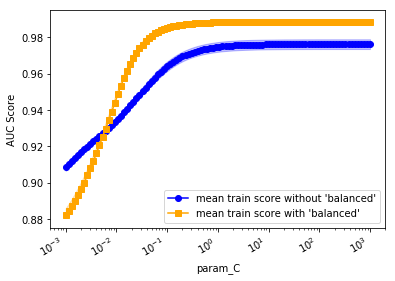

In [18]:
plt.plot(np.array(g1_lgr.cv_results_['param_C']), g1_lgr.cv_results_['mean_train_score'], marker = 'o', label="mean train score without 'balanced'", color='blue')
plt.fill_between(param_grid['C'], g1_lgr.cv_results_['mean_train_score'] - g1_lgr.cv_results_['std_train_score'], 
                 g1_lgr.cv_results_['mean_train_score'] + g1_lgr.cv_results_['std_train_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_lgr.cv_results_['param_C']), g2_lgr.cv_results_['mean_train_score'], marker = 's', label="mean train score with 'balanced'", color='orange')
plt.fill_between(param_grid['C'], g2_lgr.cv_results_['mean_train_score'] - g2_lgr.cv_results_['std_train_score'],
                 g2_lgr.cv_results_['mean_train_score'] + g2_lgr.cv_results_['std_train_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xscale("log")
plt.xlabel('param_C')
plt.ylabel('AUC Score')
plt.show()

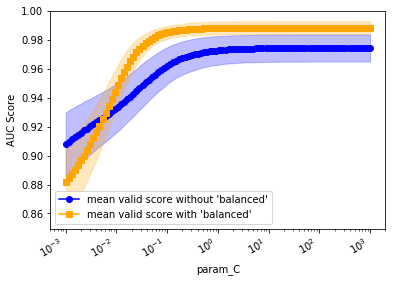

In [19]:
plt.plot(np.array(g1_lgr.cv_results_['param_C']), g1_lgr.cv_results_['mean_test_score'], marker = 'o', label="mean valid score without 'balanced'", color='blue')
plt.fill_between(param_grid['C'], g1_lgr.cv_results_['mean_test_score'] - g1_lgr.cv_results_['std_test_score'], 
                 g1_lgr.cv_results_['mean_test_score'] + g1_lgr.cv_results_['std_test_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_lgr.cv_results_['param_C']), g2_lgr.cv_results_['mean_test_score'], marker = 's', label="mean valid score with 'balanced'", color='orange')
plt.fill_between(param_grid['C'], g2_lgr.cv_results_['mean_test_score'] - g2_lgr.cv_results_['std_test_score'],
                 g2_lgr.cv_results_['mean_test_score'] + g2_lgr.cv_results_['std_test_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xscale("log")
plt.xlabel('param_C')
plt.ylabel('AUC Score')
plt.show()

Changing the class-weight to “balanced” increases the AUC scores when param_C is higher than 0.01

### Plot Average Precision Scores with Different "C"

In [20]:
param_grid = {'C' : np.logspace(-3,3,100)}
g1_lgr = GridSearchCV(LogisticRegression(), param_grid, cv=10, return_train_score=True, scoring='average_precision', iid=True)
g1_lgr.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 1.14976e-03, ..., 8.69749e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [21]:
param_grid = {'C' : np.logspace(-3,3,100)}
g2_lgr = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=10, return_train_score=True, scoring='average_precision', iid=True)
g2_lgr.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 1.14976e-03, ..., 8.69749e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

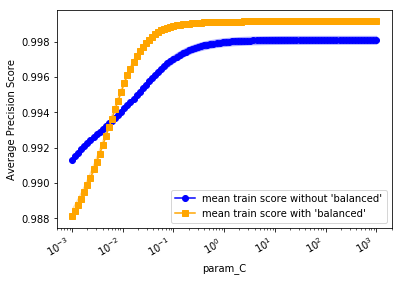

In [22]:
plt.plot(np.array(g1_lgr.cv_results_['param_C']), g1_lgr.cv_results_['mean_train_score'], marker = 'o', label="mean train score without 'balanced'", color='blue')
plt.fill_between(param_grid['C'], g1_lgr.cv_results_['mean_train_score'] - g1_lgr.cv_results_['std_train_score'], 
                 g1_lgr.cv_results_['mean_train_score'] + g1_lgr.cv_results_['std_train_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_lgr.cv_results_['param_C']), g2_lgr.cv_results_['mean_train_score'], marker = 's', label="mean train score with 'balanced'", color='orange')
plt.fill_between(param_grid['C'], g2_lgr.cv_results_['mean_train_score'] - g2_lgr.cv_results_['std_train_score'],
                 g2_lgr.cv_results_['mean_train_score'] + g2_lgr.cv_results_['std_train_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xscale("log")
plt.xlabel('param_C')
plt.ylabel('Average Precision Score')
plt.show()

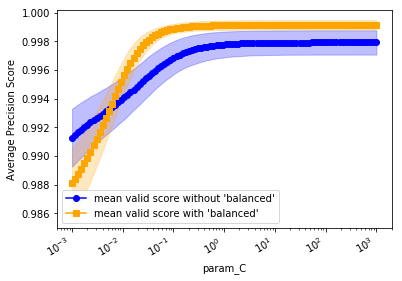

In [23]:
plt.plot(np.array(g1_lgr.cv_results_['param_C']), g1_lgr.cv_results_['mean_test_score'], marker = 'o', label="mean valid score without 'balanced'", color='blue')
plt.fill_between(param_grid['C'], g1_lgr.cv_results_['mean_test_score'] - g1_lgr.cv_results_['std_test_score'], 
                 g1_lgr.cv_results_['mean_test_score'] + g1_lgr.cv_results_['std_test_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_lgr.cv_results_['param_C']), g2_lgr.cv_results_['mean_test_score'], marker = 's', label="mean valid score with 'balanced'", color='orange')
plt.fill_between(param_grid['C'], g2_lgr.cv_results_['mean_test_score'] - g2_lgr.cv_results_['std_test_score'],
                 g2_lgr.cv_results_['mean_test_score'] + g2_lgr.cv_results_['std_test_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xscale("log")
plt.xlabel('param_C')
plt.ylabel('Average Precision Score')
plt.show()

Changing the class-weight to “balanced” increases the Average Precision scores when param_C is higher than 0.01

## RandomForestClassifier

### Plot AUC Scores with Different "max_depth"

In [24]:
param_grid = {'max_depth': range(1, 50, 1)}
g1_rf = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = param_grid, cv = 10, return_train_score=True, scoring='roc_auc', iid=True)
g1_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 50)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [25]:
param_grid = {'max_depth': range(1, 50, 1)}
g2_rf = GridSearchCV(RandomForestClassifier(random_state = 0, class_weight='balanced' ), param_grid = param_grid, cv = 10, return_train_score=True, scoring='roc_auc', iid=True)
g2_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 50)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

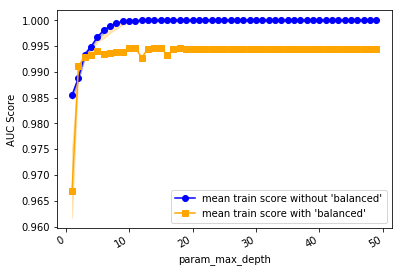

In [28]:
plt.plot(np.array(g1_rf.cv_results_['param_max_depth']), g1_rf.cv_results_['mean_train_score'], marker = 'o', label="mean train score without 'balanced'", color='blue')
plt.fill_between(param_grid['max_depth'], g1_rf.cv_results_['mean_train_score'] - g1_rf.cv_results_['std_train_score'], 
                 g1_rf.cv_results_['mean_train_score'] + g1_rf.cv_results_['std_train_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_rf.cv_results_['param_max_depth']), g2_rf.cv_results_['mean_train_score'], marker = 's', label="mean train score with 'balanced'", color='orange')
plt.fill_between(param_grid['max_depth'], g2_rf.cv_results_['mean_train_score'] - g2_rf.cv_results_['std_train_score'],
                 g2_rf.cv_results_['mean_train_score'] + g2_rf.cv_results_['std_train_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xlabel('param_max_depth')
plt.ylabel('AUC Score')
plt.show()

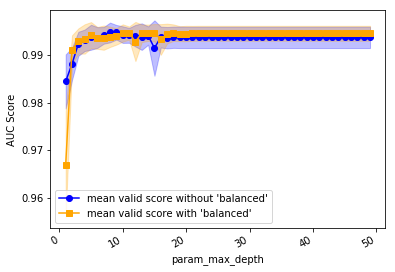

In [29]:
plt.plot(np.array(g1_rf.cv_results_['param_max_depth']), g1_rf.cv_results_['mean_test_score'], marker = 'o', label="mean valid score without 'balanced'", color='blue')
plt.fill_between(param_grid['max_depth'], g1_rf.cv_results_['mean_test_score'] - g1_rf.cv_results_['std_test_score'], 
                 g1_rf.cv_results_['mean_test_score'] + g1_rf.cv_results_['std_test_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_rf.cv_results_['param_max_depth']), g2_rf.cv_results_['mean_test_score'], marker = 's', label="mean valid score with 'balanced'", color='orange')
plt.fill_between(param_grid['max_depth'], g2_rf.cv_results_['mean_test_score'] - g2_rf.cv_results_['std_test_score'],
                 g2_rf.cv_results_['mean_test_score'] + g2_rf.cv_results_['std_test_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xlabel('param_max_depth')
plt.ylabel('AUC Score')
plt.show()

Changing the class-weight to “balanced” does not increase the AUC scores.

### Plot Average Precision Scores with Different "max_depth"

In [30]:
param_grid = {'max_depth': range(1, 50, 1)}
g1_rf = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid = param_grid, cv = 10, return_train_score=True, scoring='average_precision', iid=True)
g1_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 50)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='average_precision',
       verbose=0)

In [31]:
param_grid = {'max_depth': range(1, 50, 1)}
g2_rf = GridSearchCV(RandomForestClassifier(random_state = 0, class_weight='balanced'), param_grid = param_grid, cv = 10, return_train_score=True, scoring='average_precision', iid=True)
g2_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 50)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='average_precision',
       verbose=0)

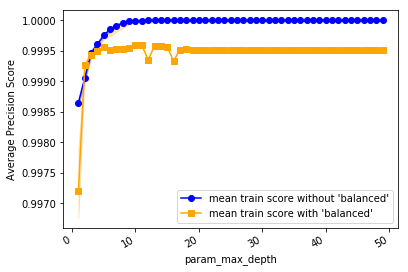

In [32]:
plt.plot(np.array(g1_rf.cv_results_['param_max_depth']), g1_rf.cv_results_['mean_train_score'], marker = 'o', label="mean train score without 'balanced'", color='blue')
plt.fill_between(param_grid['max_depth'], g1_rf.cv_results_['mean_train_score'] - g1_rf.cv_results_['std_train_score'], 
                 g1_rf.cv_results_['mean_train_score'] + g1_rf.cv_results_['std_train_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_rf.cv_results_['param_max_depth']), g2_rf.cv_results_['mean_test_score'], marker = 's', label="mean train score with 'balanced'", color='orange')
plt.fill_between(param_grid['max_depth'], g2_rf.cv_results_['mean_train_score'] - g2_rf.cv_results_['std_train_score'],
                 g2_rf.cv_results_['mean_train_score'] + g2_rf.cv_results_['std_train_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xlabel('param_max_depth')
plt.ylabel('Average Precision Score')
plt.show()

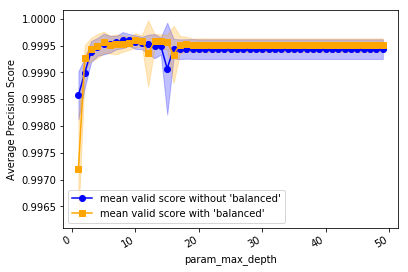

In [33]:
plt.plot(np.array(g1_rf.cv_results_['param_max_depth']), g1_rf.cv_results_['mean_test_score'], marker = 'o', label="mean valid score without 'balanced'", color='blue')
plt.fill_between(param_grid['max_depth'], g1_rf.cv_results_['mean_test_score'] - g1_rf.cv_results_['std_test_score'], 
                 g1_rf.cv_results_['mean_test_score'] + g1_rf.cv_results_['std_test_score'], alpha=0.25, color='blue')

plt.plot(np.array(g2_rf.cv_results_['param_max_depth']), g2_rf.cv_results_['mean_test_score'], marker = 's', label="mean valid score with 'balanced'", color='orange')
plt.fill_between(param_grid['max_depth'], g2_rf.cv_results_['mean_test_score'] - g2_rf.cv_results_['std_test_score'],
                 g2_rf.cv_results_['mean_test_score'] + g2_rf.cv_results_['std_test_score'], alpha=0.25,
                 color="orange")

plt.legend(loc="best")
plt.xticks(rotation=30,ha="right")
plt.xlabel('param_max_depth')
plt.ylabel('Average Precision Score')
plt.show()

Changing the class-weight to “balanced” does not increase the Average Precision scores.